In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/nfs/pic.es/user/m/mbilkis/qmon-sindy")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 
from numerics.NN.models.osc_exp_dec import *
from numerics.NN.misc import * 
from numerics.NN.losses import * 

import torch
import numpy as np
from scipy.linalg import solve_continuous_are
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
mode="osc-exp-dec"

In [21]:
itraj = 1
x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
####
params, exp_path = give_params(mode=mode)
gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)
###
printing=True

In [22]:
torch.manual_seed(0)

dev = torch.device("cpu")

gf = .1
wf=.7
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [[200.,0], [[-gf,wf],[-wf,-gf]]  ]]

rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

xs_hat, dys_hat, fs_hats = rrn(dys)
loss = log_lik(dys, dys_hat)
history = {}
history["losses"] = [ [loss.item(),err_f(f[:,0],fs_hats[:,0])]  ]
history["params"] = [[k.detach().data for k in list(rrn.parameters())]]
history["gradients"] = []


if printing==True:

    print(loss.item())
    print(err_f(f[:,0],fs_hats[:,0]))
    print(history["params"][-1])
    print("\n")

for ind in range(3000):
    xs_hat, dys_hat, fs_hats = rrn(dys)
    loss = log_lik(dys, dys_hat, dt=dt)
    loss.backward()
    signal_distance = err_f(f[:,0],fs_hats[:,0])
    optimizer.step()


    history["losses"].append([loss.item(),signal_distance] )
    history["params"].append([k.detach().data for k in copy.deepcopy(list(rrn.parameters()))])
    history["gradients"].append(copy.deepcopy([k.grad.numpy() for k in list(rrn.parameters())]))

    if printing==True:

        print("**** iteration {} ****".format(ind))
        print(loss.item())
        print(signal_distance)
        print(history["params"][-1])
        print("\n")
    optimizer.zero_grad()
    save_history(history, itraj=itraj, exp_path=exp_path,what="ejemplo_osc_exp_dec")

    if np.abs(loss.item()) < 1+1e-7:
        break


2.1930763721466064
2.577865106642022
[tensor([200.,   0.]), tensor([[[-0.1000,  0.7000],
         [-0.7000, -0.1000]]])]


**** iteration 0 ****
1.7451947927474976
2.577865106642022
[tensor([ 1.9999e+02, -9.9999e-03]), tensor([[[-0.1100,  0.7100],
         [-0.7100, -0.1100]]])]


**** iteration 1 ****
1.712845802307129
2.495401019358534
[tensor([ 1.9998e+02, -1.9996e-02]), tensor([[[-0.1200,  0.7200],
         [-0.7200, -0.1200]]])]


**** iteration 2 ****
1.6831997632980347
2.4167971316338113
[tensor([ 1.9997e+02, -2.9984e-02]), tensor([[[-0.1299,  0.7300],
         [-0.7300, -0.1299]]])]


**** iteration 3 ****
1.6560850143432617
2.341938072776935
[tensor([ 1.9996e+02, -3.9959e-02]), tensor([[[-0.1397,  0.7399],
         [-0.7399, -0.1397]]])]


**** iteration 4 ****
1.6313164234161377
2.270480027055123
[tensor([ 1.9995e+02, -4.9916e-02]), tensor([[[-0.1495,  0.7498],
         [-0.7498, -0.1494]]])]


**** iteration 5 ****
1.6087079048156738
2.202346579899586
[tensor([ 1.9994e+02, -

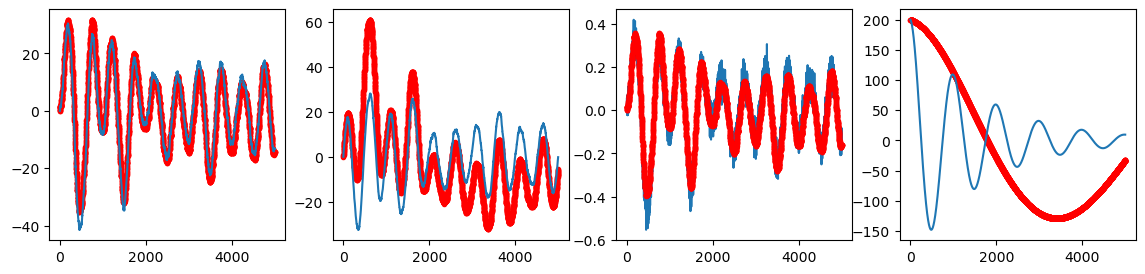

In [199]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(ixs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(ixs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(idys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(ifs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])


Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

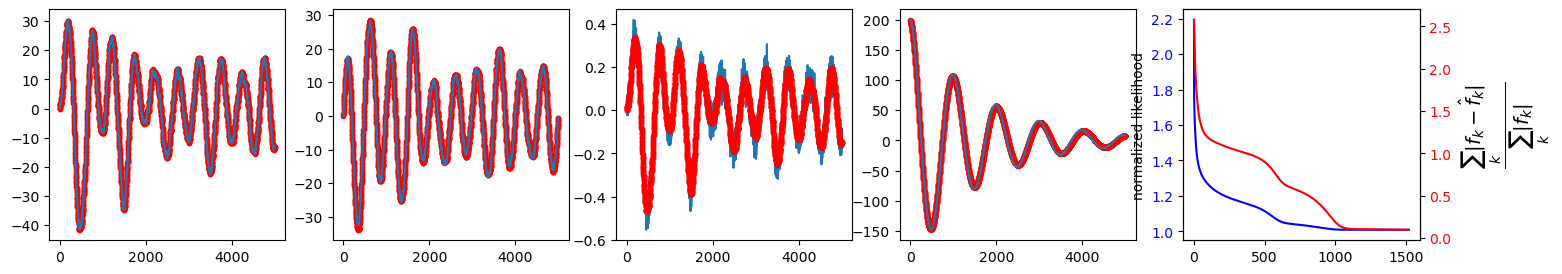

In [175]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])

ax=plt.subplot(175)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)

In [184]:
Ahist = np.squeeze(np.stack([history["params"][k][1] for k in range(len(history["params"]))]))
f0 = np.squeeze(np.stack([history["params"][k][0] for k in range(len(history["params"]))]))

In [188]:
true_gamma = b[1][0]
true_omega = b[1][1]
true_f0 = b[0][0]
true_f0_dot = b[0][1]

In [195]:
Ahist[-1]

array([[-0.90564907,  4.9382286 ],
       [-4.9314656 , -0.12887985]], dtype=float32)

In [206]:
Atrue = np.array([[true_gamma, true_omega],[-true_omega, true_gamma]] )

In [202]:
Atrue

[[-0.5, 5.0], [-5.0, -0.5]]

Text(0.5, 0, 'epochs')

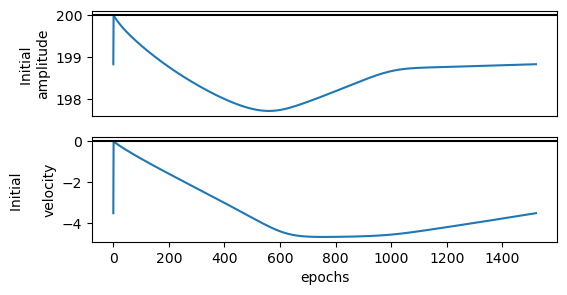

In [220]:
fig=plt.figure(figsize=(6,3))
ax=plt.subplot(211)
ax.plot(f0[:,0])
ax.set_ylabel("Initial \namplitude")
ax.set_xticks([])
ax.axhline(true_f0,color="black")
ax=plt.subplot(212)
ax.plot(f0[:,1])
ax.set_ylabel("Initial \n \nvelocity")
ax.axhline(true_f0_dot,color="black")
ax.set_xlabel("epochs")

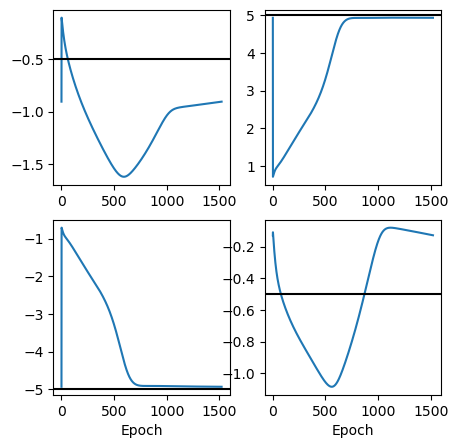

In [214]:
plt.figure(figsize=(5,5))
plt.tight_layout()
posis=[221,222,223,224]
k=0
for i in range(2):
    for j in range(2):
        ax=plt.subplot(posis[k])
        ax.plot(Ahist[:,i,j], label="pred")
        ax.axhline(Atrue[i,j],color="black")
        if k in [0,1]:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("Epoch")            
        k+=1


In [182]:
np.squeeze(Ahist).shape

(1522, 2, 2)

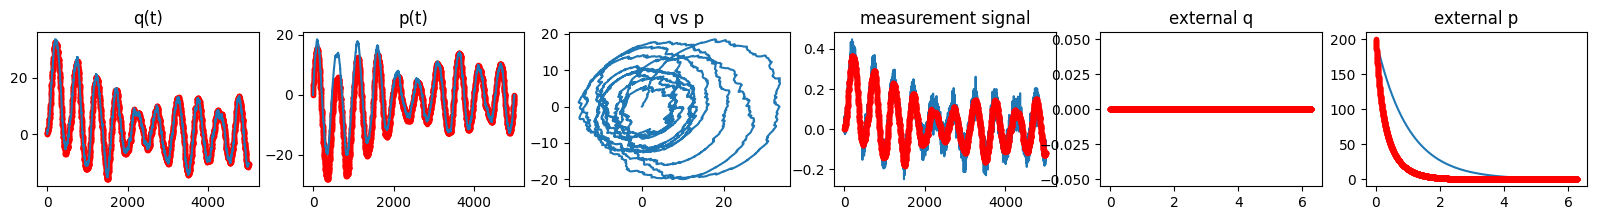